In [5]:
import pyterrier as pt
import ir_datasets
import os
import matplotlib.pyplot as plt

In [ ]:
# pt.init()

In [6]:
ds = pt.get_dataset("irds:disks45/nocr/trec-robust-2004")
print(ds)

INDEX_DIR = "./robust04_index_customfeatures"
os.makedirs(INDEX_DIR, exist_ok=True)

INDEX_DIR = os.path.abspath("./robust04_index_customfeatures")

IRDSDataset('disks45/nocr/trec-robust-2004')


## new index part

In [10]:
META_FIELD_LENGTHS = {"docno": 20, "body": 10000}
INDEXER_PROPERTIES = {"meta.reverse.keys": "docno,body"}

indexer = pt.IterDictIndexer(
        INDEX_DIR,

        text_attrs = ['body'],
        meta = META_FIELD_LENGTHS,
        properties = INDEXER_PROPERTIES
)

index_ref = indexer.index(ds.get_corpus_iter())

print("Finished")

Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
disks45/nocr/trec-robust-2004 documents:  25%|██▍       | 130529/528155 [04:19<30:51, 214.78it/s] 

21:49:00.191 [main] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (FR940104-2-00103) - further warnings are suppressed


disks45/nocr/trec-robust-2004 documents: 100%|█████████▉| 527970/528155 [19:11<00:00, 458.42it/s]  
Traceback (most recent call last):
  File "jnius/jnius_proxy.pxi", line 50, in jnius.PythonJavaClass.invoke
  File "jnius/jnius_proxy.pxi", line 76, in jnius.PythonJavaClass._invoke
  File "c:\Users\nienk\VSCodeProjects\InformationRetrival\.venv\Lib\site-packages\pyterrier\utils.py", line 142, in _wrapper
    return fn(*args, **kwargs)
  File "c:\Users\nienk\VSCodeProjects\InformationRetrival\.venv\Lib\site-packages\pyterrier\terrier\java.py", line 294, in next
    self._next = next(self._it, StopIteration)
                 ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nienk\VSCodeProjects\InformationRetrival\.venv\Lib\site-packages\pyterrier\terrier\index.py", line 617, in <genexpr>
    return ({f: doc[f] for f in all_cols} for doc in it)
                                                     ^^
  File "c:\Users\nienk\VSCodeProjects\InformationRetrival\.venv\Lib\site-packages\pyterrier\d

22:03:52.386 [main] WARN org.terrier.structures.indexing.Indexer -- skipping null document
22:04:40.092 [main] WARN org.terrier.structures.indexing.Indexer -- Indexed 126 empty documents
Finished


In [11]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics())

22:06:04.960 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
Number of documents: 527970
Number of terms: 518597
Number of postings: 81882805
Number of fields: 0
Number of tokens: 141200305
Field names: []
Positions:   false



In [12]:
meta_index = index.getMetaIndex()

print(meta_index.getKeys())
print(list(meta_index.getReverseKeys()))

['docno', 'body']
['docno']


## XG Boost Part

In [15]:
import os
import pyterrier as pt
import pandas as pd
import xgboost as xgb
import re

In [16]:
#Function 1
def count_term_in_body_unique(row, meta_index):
    """
    Counts how many unique terms in the query appear in the document body.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return 0

    body = meta_index.getItem("body", docid)

    body_terms = set(body.lower().split())
    query_terms = set(row["query"].lower().split())

    count = sum(1 for term in query_terms if term in body_terms)
    return count

In [17]:
#Function 2
def count_term_in_body_full(row, meta_index):
    """
    Counts the total occurrences of query terms in the document body.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return 0

    body = meta_index.getItem("body", docid) or ""

    body_terms = body.lower().split()
    query_terms = row["query"].lower().split()

    # Count total occurrences
    count = sum(body_terms.count(term) for term in query_terms)
    return count

In [18]:
#Function3 
def query_coverage_first_200(row, meta_index):
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)
    if docid == -1:
        return 0.0
    
    body = meta_index.getItem("body", docid) or ""

    body_terms = body.lower().split()[:200]
    query_terms = row["query"].lower().split()
    if not query_terms:
        return 0.0
    
    matched_terms = sum(1 for term in query_terms if term in body_terms)
    return float(matched_terms / len(query_terms))


In [26]:
#Fuction 4 
def count_doc_length(row, meta_index):
    """
    Counts the total number of words in the document body.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return 0

    body = meta_index.getItem("body", docid) or ""

    return len(body.split())

In [ ]:
#Function 5 
def count_query_length(row, meta_index=None):
    """
    Counts the total number of words in the query.
    """
    query = row["query"] or ""
    return len(query.split())

In [37]:
#Function 6 
def query_document_length_ratio(row, meta_index):
    """
    Computes the ratio: document_length / query_length.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return 0

    body = meta_index.getItem("body", docid) or ""
    doc_length = len(body.split())

    query = row["query"] or ""
    query_length = len(query.split())

    if query_length == 0:
        return 0

    return doc_length / query_length

In [38]:
#Function 7 
def first_query_term_position(row, meta_index):
    """
    Returns the first position (0-based index) of any query term in the document body.
    """
    docno = row["docno"]
    docid = meta_index.getDocument("docno", docno)

    if docid == -1:
        return -1

    body = meta_index.getItem("body", docid) or ""
    body_terms = body.lower().split()

    query_terms = set(row["query"].lower().split())

    for i, term in enumerate(body_terms):
        if term in query_terms:
            return i

    return -1

In [19]:
#Testing the functions on an example:
docid = 0
body = meta_index.getItem("body", docid)
docno = meta_index.getItem("docno", docid)

# print("DOCNO:", docno)
# print("BODY:", body[:300])

test_row = {
    "docno": docno,
    "query": "example query relative. the and"
}


count_unique = count_term_in_body_unique(test_row, meta_index)
print("\nNumber of unique query terms in document:", count_unique)

count_full = count_term_in_body_full(test_row, meta_index)
print("\nNumber of query terms in document in total:", count_full)


Number of unique query terms in document: 2

Number of query terms in document in total: 60


In [41]:
# Creating format for the pipeline  

custom_feature_transformer_unique = pt.apply.doc_score(
    lambda row: count_term_in_body_unique(row, meta_index)
)

custom_feature_transformer_full = pt.apply.doc_score(
    lambda row: count_term_in_body_full(row, meta_index)
)

custom_feature_coverage_200 = pt.apply.doc_score(
    lambda row: query_coverage_first_200(row, meta_index)
)

custom_feature_coverage_doc_length = pt.apply.doc_score(
    lambda row: count_doc_length(row, meta_index)
)

custom_feature_coverage_query_length = pt.apply.doc_score(
    lambda row: count_query_length(row, meta_index)
)

custom_feature_ratio = pt.apply.doc_score(
    lambda row: query_document_length_ratio(row, meta_index)
)

custom_feature_first_match = pt.apply.doc_score(
    lambda row: first_query_term_position(row, meta_index)
)

In [42]:
topics = ds.get_topics().rename(columns={"title": "query"})
topics["query"] = topics["query"].apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', ' ', x))
qrels = ds.get_qrels()

split = int(len(topics) * 0.8)
train_topics = topics.iloc[:split]
valid_topics = topics.iloc[split:]
train_qrels = qrels[qrels["qid"].isin(train_topics["qid"])]
valid_qrels = qrels[qrels["qid"].isin(valid_topics["qid"])]


bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
tf = pt.terrier.Retriever(index_ref, wmodel="Tf")
pl2 = pt.terrier.Retriever(index_ref, wmodel="PL2")

features = []

pipeline = bm25 >> (tf ** pl2 ** custom_feature_transformer_unique ** custom_feature_transformer_full**custom_feature_coverage_200**custom_feature_coverage_doc_length**custom_feature_coverage_query_length**custom_feature_ratio**custom_feature_first_match)

xgb_ranker = xgb.XGBRanker(
    objective="rank:ndcg",
    learning_rate=0.1,
    gamma=1.0,
    min_child_weight=0.1,
    max_depth=6,
    random_state=42
)

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
22:46:33.063 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
22:46:33.223 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.
22:46:33.359 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 673,3 MiB of memory would be required.


In [43]:
ltr_pipeline = pipeline >> pt.ltr.apply_learned_model(xgb_ranker, form="ltr")

ltr_pipeline.fit(train_topics, train_qrels, valid_topics, valid_qrels)

In [44]:
results = ltr_pipeline.transform(valid_topics)
results.to_csv("ltr_results_nn.csv", index=False)
print(results.head(10))

   qid   docid          docno     score                   query  \
0  651  335499    FT941-13121  0.491641  U S  ethnic population   
1  651   36640    FBIS3-36641  0.363876  U S  ethnic population   
2  651  111209    FBIS4-49817  0.439439  U S  ethnic population   
3  651  222897     FT922-2504  0.387049  U S  ethnic population   
4  651   93471    FBIS4-32079  0.202204  U S  ethnic population   
5  651  251148     FT924-1179 -0.050889  U S  ethnic population   
6  651  110379    FBIS4-48987 -0.501211  U S  ethnic population   
7  651  101239    FBIS4-39847 -0.664377  U S  ethnic population   
8  651  230420     FT923-9432 -0.294800  U S  ethnic population   
9  651  517050  LA120190-0057 -0.139378  U S  ethnic population   

                                         description  \
0  How is the ethnic make-up of the U.S. populati...   
1  How is the ethnic make-up of the U.S. populati...   
2  How is the ethnic make-up of the U.S. populati...   
3  How is the ethnic make-up of the U.

<bound method RegressionTransformer.transform of <pyterrier.ltr.LTRTransformer object at 0x0000028A230EC190>>


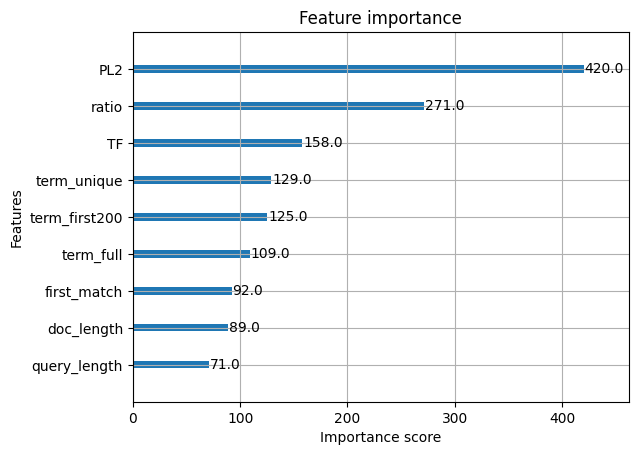

In [46]:
# Weight: Number of times a feature is used in splits.
# Gain: Average improvement in the loss function when the feature is used.
# Cover: Average number of samples affected by splits using the feature.

print(ltr_pipeline[-1].transform)
skle = ltr_pipeline[-1].learner
xgboo = skle.get_booster()
xgboo.feature_names = ["TF",
                       "PL2",
                       "term_unique",
                       "term_full",
                       "term_first200",
                       "doc_length",
                       "query_length", 
                       "ratio", 
                       "first_match",
                       ]
xgb.plot_importance(xgboo,importance_type = "weight")
plt.show()   

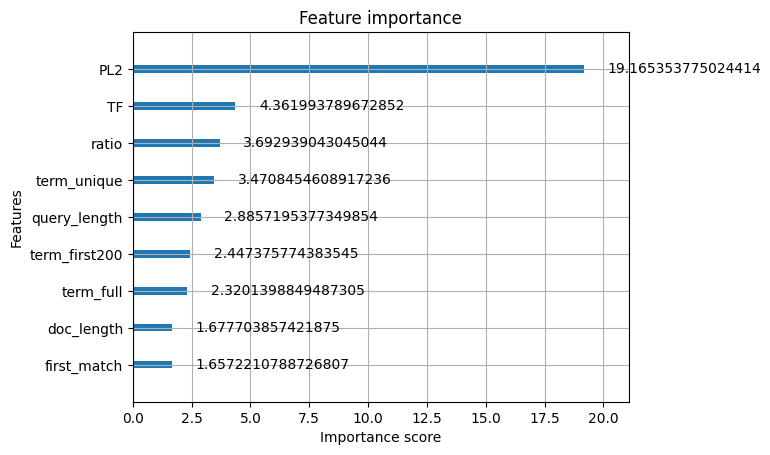

In [47]:
xgb.plot_importance(xgboo,importance_type = "gain")
plt.show()

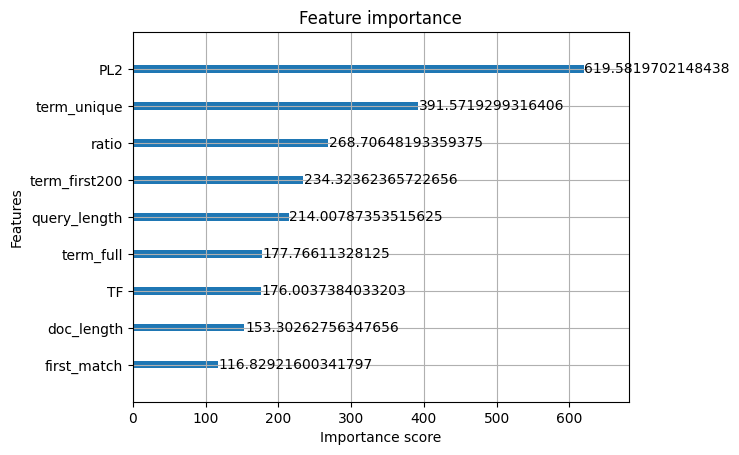

In [48]:
xgb.plot_importance(xgboo,importance_type = "cover")
plt.show()   

In [ ]:
evalution = pt.Experiment([ltr_pipeline],valid_topics,valid_qrels, eval_metrics=["map", "ndcg_cut_10"])

df_eval = pd.DataFrame(evalution)
excel_path = "evaluation_results.xlsx"
sheet_name = "Results"

if os.path.exists(excel_path):
    existing = pd.read_excel(excel_path, sheet_name=sheet_name)
    combined = pd.concat([existing, df_eval], ignore_index=True)
    combined.to_excel(excel_path, sheet_name=sheet_name, index=False)
else:
    df_eval.to_excel(excel_path, sheet_name=sheet_name, index=False)

print(eval) 

disks45/nocr/trec-robust-2004 documents:   0%|          | 0/528155 [12:24<?, ?it/s]


PermissionError: [Errno 13] Permission denied: 'evaluation_results.xlsx'